In [1]:
import sys
sys.path.append('/home/jovyan/modules')
from pre import *
from connectors import *

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,5)})
plt.style.use('ggplot')

1) Выбираем kvi по методологии https://wiki.sbmt.io/pages/viewpage.action?pageId=3116883565

2) (для простоты выбираем стор)) - смотрит доступность этих товаров в определенные дни (например более половины дня/ хоть раз) или часы 

3) смотрим конверсию в заказ в эти дни

4) строим регрессию




Ограничения - во всех сторах Ашана за последний месяц

Как признак - день недели, конв в предыдущий день, kvi разбить по мк 

Как результат - оценим влияние доступности топ товаров на конверсию в заказ

По суткам все же, + день недели, деньги объясняют предыдущий день

# Выбираем kvi товары - top_kvi

In [2]:
def get_q(start_date,end_date ):
    q=f'''
with multiretail_evnt as 
   (
    select params['product_name'] product_name,
        order_id,
        count(*) as quantity
from event.new_app
where dwh_dt between toDate('{start_date}') and toDate('{end_date}')
  and ts between  toDate('{start_date}') and toDate('{end_date}')
  and event = 'Product Added'
  and source='search_multiretail'
  and anonymous_id != '' 
  and retailer_id in (1, 8, 15)
  and order_id > ''
  and toUInt64(store_id) not in (18, 178, 179, 1074)
  group by product_name, order_id 
  
  ) ,
  multiretail_added as (
  select product_name,
         'multiretail' as marker,
         sum(quantity) as added_quantity,
         count(*) over () as multiretail_total,
         row_number() over (order by added_quantity desc) as multiretail_rn
  from multiretail_evnt
  group by product_name
  order by added_quantity desc
), 
li_fist_products as (
select shipment_id,
       any(user_id) as user_id,
       argMin(product_name, li_created_at) as first_product
from line_items
where shipment_shipped_at between  toDate('{start_date}') and toDate('{end_date}')
    and retailer_id in (1, 8, 15)
group by shipment_id
),
fist_products as (
select first_product as product_name,
        'first_in_cart' as marker,
       count() as orders_count,
       count(*) over () as first_total,
       row_number() over (order by orders_count desc) as first_rn
from li_fist_products
group by first_product
order by orders_count desc
),
top_gmv_products as (
select product_name as product_name,
     'gmv_top' as marker,
    sum(price*quantity) as gmv,
    count(*) over () as gmv_total,
    row_number() over (order by gmv desc) as gmv_rn
from line_items
where li_deleted_at is null
    and shipment_state = 'shipped'
    and shipment_shipped_at between toDate('{start_date}') and toDate('{end_date}')
    and product_name != ''
    and retailer_id in (1, 8, 15)
group by product_name
order by gmv desc
),
penetration as (
select product_name, 'penetration_top' as marker, uniqExact(user_id) as users,
        count(*) over () as penetration_total,
        row_number() over (order by users desc) as penetration_rn
from line_items 
where shipment_shipped_at between  toDate('{start_date}') and toDate('{end_date}')
    and li_deleted_at is null
    and shipment_state = 'shipped'
    and retailer_id in (1, 8, 15)
group by product_name
order by users desc
),
search_evnt as 
   (
    select 
    params['product_name'] product_name,
    order_id,
    count(*) as quantity
from event.new_app
where dwh_dt between  toDate('{start_date}') and toDate('{end_date}')
  and ts between  toDate('{start_date}') and toDate('{end_date}')
  and event = 'Product Added'
  and source='search'
  and anonymous_id != '' 
  and retailer_id in (1, 8, 15)
  and order_id > ''
  and toUInt64(store_id) not in (18, 178, 179, 1074)
  group by product_name, order_id 
  ),
  search_added as (
  select product_name,
         'search' as marker,
         sum(quantity) as added_quantity,
         count(*) over () as search_total,
         row_number() over (order by added_quantity desc) as search_rn
  from search_evnt
  group by product_name
  order by added_quantity desc
),
all_markers as (
select product_name, marker, multiretail_rn as r
from multiretail_added
where multiretail_rn <= 10000


union all
select product_name, marker, first_rn
from fist_products
where first_rn <= 10000


union all
select product_name, marker, gmv_rn
from top_gmv_products
where gmv_rn <= 10000
union all
select product_name, marker, penetration_rn
from penetration
where penetration_rn <= 10000
union all
select product_name, marker, search_rn
from search_added
where search_rn <= 10000
),

need_products as (
select distinct product_name, sku, 
groupUniqArray(retailer_id) as retailers
from line_items
where li_deleted_at is null
    and shipment_state = 'shipped'
    and shipment_shipped_at between  toDate('{start_date}') and toDate('{end_date}')
    and product_name != ''
    and retailer_id in (1, 8, 15)
group by product_name,sku
having uniqExact(retailer_id) >1
)
select product_name
, sum(r) as sum_r
, sku

from all_markers 
    join need_products on all_markers.product_name = need_products.product_name
group by product_name,sku,retailers
order by sum_r asc
limit 5000


'''
    return q

In [3]:
try:
    top_kvi = pd.read_feather('DATA-30893/top_kvi.feather')
except:
    top_kvi = read_sql_query(get_q('2024-01-01','2024-03-20'))
    top_kvi.to_feather('DATA-30893/top_kvi.feather')

In [4]:
print(top_kvi.shape)
top_kvi.head()

(5000, 3)


,product_name,sum_r,sku
0,Бананы,6,10712
1,Огурцы среднеплодные гладкие,22,30669
2,Огурцы короткоплодные,89,30105
3,"Молоко 2,5% пастеризованное 930 мл Простоквашино БЗМЖ",95,15294886
4,"Молоко 3,2% ультрапастеризованное 925 мл Домик в деревне БЗМЖ",132,10176


# Проверка доступности товаров

* Сырые данные
    * iceberg.dwh_raw_producthub.raw_stock_2 - стоки
    * iceberg.dwh_raw_producthub.raw_offer - офферы
    * iceberg.dwh_raw_producthub.raw_updated_sku - цены
    * iceberg.dwh_raw_producthub.raw_product - карточки товара

Доступность = ненулевой сток, оффер, цена, карточка

In [7]:
ret_id = 15
date_start = '2024-03-01'
date_end = '2024-03-20'

In [6]:
stores_df = \
read_sql_query(f'''
select id as store_id, retailer_id
from int_stores 
where available_on < now()
and retailer_id = {ret_id} and training = 0

''')

## Стоки

In [8]:
try:
    stock_data_deltas = pd.read_feather('DATA-30893/stock_data_deltas.feather')
    stock_data_agg = pd.read_feather('DATA-30893/stock_data_agg.feather')
except:
    
    q = f'''
    select published
    , dt
    , product_sku
    , store_id
    , retailer_id

    from iceberg.dwh_raw_producthub.raw_stock_2
    where store_id in {tuple(stores_df.store_id.to_list())} 
    and retailer_id = {ret_id} 
    and product_sku in {tuple(top_kvi.sku.astype(int).to_list())}
    and dt between date '{date_start}' and date '{date_end}' 


    --? and ab_group =''
    '''
    stock_data = read_sql_query(q, con = 'trino')
    stock_data['dt'] = pd.to_datetime(stock_data['dt'])
    
    stock_data_deltas = \
    stock_data[['published','dt','product_sku','store_id','retailer_id']]\
    .drop_duplicates().sort_values(by = 'dt')
    stock_data_deltas['prev_published'] = stock_data_deltas.groupby(['product_sku','store_id','retailer_id'])['published'].shift(1)
    
    stock_data_deltas = stock_data_deltas[stock_data_deltas['prev_published']!=stock_data_deltas['published']].reset_index(drop=True)
    stock_data_deltas['prev_published_time'] = stock_data_deltas.groupby(['product_sku','store_id','retailer_id'])['dt'].shift(1)
    stock_data_deltas['time_delta'] = stock_data_deltas['dt'] - stock_data_deltas['prev_published_time']
    stock_data_deltas = stock_data_deltas[['retailer_id','store_id','product_sku','prev_published_time','dt','prev_published','time_delta','published']]

    stock_data_deltas.columns = ['retailer_id','store_id','product_sku','from_time','to_time','status','time_delta','cur_status']
    stock_data_deltas.to_feather('DATA-30893/stock_data_deltas.feather')
    
    stock_data_agg = stock_data.groupby(['retailer_id', 'store_id', 'product_sku']).agg({'dt':['min','max'],'published':['nunique','unique']}).reset_index()
    stock_data_agg.columns = [x[0]+"_"+x[1] if x[1] else x[0] for x in stock_data_agg.columns]
    stock_data_agg.to_feather('DATA-30893/stock_data_agg.feather')


In [11]:
stock_data_deltas['to_time'] = stock_data_deltas['to_time'].dt.tz_localize(None)
stock_data_deltas['from_time'] = stock_data_deltas['from_time'].dt.tz_localize(None)

In [12]:
# Товары, у которых был только один статус стока
easy_peasy_stocks \
    = stock_data_deltas.merge(stock_data_agg[stock_data_agg.published_nunique ==1 ][['retailer_id','store_id','product_sku']], how = 'inner')

In [13]:
# Товары, у которых было больше одного статуса стока
stock_data_deltas_not_easy = stock_data_deltas.merge(stock_data_agg[stock_data_agg.published_nunique ==1 ][['retailer_id','store_id','product_sku']], how = 'outer', indicator = True)\
    .query('_merge == "left_only"')
stock_data_deltas_not_easy['from_time'].fillna(pd.to_datetime(date_start), inplace = True)
stock_data_deltas_not_easy.head()

,retailer_id,store_id,product_sku,from_time,to_time,status,time_delta,cur_status,_merge
0,15,282,70024,2024-03-01 00:00:00.000,2024-03-01 00:00:07.371,None,NaT,True,left_only
1,15,282,70024,2024-03-01 00:00:07.371,2024-03-01 00:00:07.426,True,0 days 00:00:00.055000,False,left_only
2,15,282,70024,2024-03-01 00:00:07.426,2024-03-01 05:43:48.871,False,0 days 05:43:41.445000,True,left_only
3,15,282,70024,2024-03-01 05:43:48.871,2024-03-01 05:43:49.048,True,0 days 00:00:00.177000,False,left_only
4,15,282,70024,2024-03-01 05:43:49.048,2024-03-01 07:11:51.904,False,0 days 01:28:02.856000,True,left_only


In [14]:
# кейсы как могут пересекаться отрезки: понадобится, чтобы для конкретного дня опеределить - сколько часов в нем товар был в выбранном статусе
# 1. a1 < b1 < a2 < b2 -> a2-b1
# 2. b1 < a1 < b2 < a2 -> b2-a1
# 3. a1 < a2 < b1 < b2 -> 0
# 4. b1 < b2 < a1 < a2 -> 0
# 5. a1 < b1 < b2 < a2 -> b2-b1
# 6. b1 < a1 < a2 < b2 -> a2-a1

def get_intersection(a1,a2,b1,b2):
    if a1 <= b1 <= a2 <= b2:
        return a2-b1
    elif b1 <= a1 <= b2 <= a2:
        return b2-a1
    elif a1 <= b1 <= b2 <= a2:
        return b2-b1
    elif b1 <= a1 <= a2 <= b2:
        return a2-a1
    else:
        return dt.timedelta(0)
    

In [18]:
# Получили для каждого дня и скю - сколько времени товар был в каждом статусе
try:
    stock_data_deltas_not_easy = pd.read_feather('DATA-30893/stock_data_deltas_not_easy_agg.feather')
except:
    for el in tqdm(pd.date_range(start = date_start, end = date_end)):
        el_plus_1 = (el + dt.timedelta(days=1))
        
        stock_data_deltas_not_easy[el.strftime('%Y-%m-%d')] = stock_data_deltas_not_easy.apply(lambda x: get_intersection(el, el_plus_1, x.from_time, x.to_time), axis = 1)

    stock_data_deltas_not_easy.to_feather('DATA-30893/stock_data_deltas_not_easy_agg.feather')

stock_data_deltas_not_easy.head()

,retailer_id,store_id,product_sku,from_time,to_time,status,time_delta,cur_status,_merge,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20
0,15,282,70024,2024-03-01 00:00:00.000,2024-03-01 00:00:07.371,None,NaT,True,left_only,0 days 00:00:07.371000,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
1,15,282,70024,2024-03-01 00:00:07.371,2024-03-01 00:00:07.426,True,0 days 00:00:00.055000,False,left_only,0 days 00:00:00.055000,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
2,15,282,70024,2024-03-01 00:00:07.426,2024-03-01 05:43:48.871,False,0 days 05:43:41.445000,True,left_only,0 days 05:43:41.445000,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
3,15,282,70024,2024-03-01 05:43:48.871,2024-03-01 05:43:49.048,True,0 days 00:00:00.177000,False,left_only,0 days 00:00:00.177000,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
4,15,282,70024,2024-03-01 05:43:49.048,2024-03-01 07:11:51.904,False,0 days 01:28:02.856000,True,left_only,0 days 01:28:02.856000,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days


In [43]:
stock_data_deltas_not_easy_modifies = pd.DataFrame()
for el in tqdm(pd.date_range(start = date_start, end = date_end)):
    tmp = stock_data_deltas_not_easy[[el.strftime('%Y-%m-%d'),'retailer_id','store_id','product_sku','cur_status']]
    tmp.columns = ['time_delta','retailer_id','store_id','product_sku','cur_status']
    tmp = tmp.groupby(['retailer_id','store_id','product_sku','cur_status'])[['time_delta']].sum().reset_index()
    tmp['time_delta'] = tmp['time_delta'].apply(lambda x: x.total_seconds())
    tmp['observed_date'] = el
    stock_data_deltas_not_easy_modifies = stock_data_deltas_not_easy_modifies.append(tmp)
    
stock_data_deltas_not_easy_modifies.head()

100%|██████████| 20/20 [10:35<00:00, 31.79s/it]


,retailer_id,store_id,product_sku,cur_status,time_delta,observed_date
0,15,70,10060,False,86398.761,2024-03-01
1,15,70,10060,True,1.239,2024-03-01
2,15,70,10061,False,73993.976,2024-03-01
3,15,70,10061,True,12406.024,2024-03-01
4,15,70,10166,False,73995.194,2024-03-01


In [37]:
1.81/8.64

0.20949074074074073

In [44]:
stock_data_deltas_not_easy_modifies.reset_index(drop=True, inplace = True)

In [45]:
# в среднем товары были доступны 1.81/8.64 = 20% дня
stock_data_deltas_not_easy_modifies.query('cur_status==True').time_delta.describe()

count    3.325580e+06
mean     1.809795e+04
std      3.164330e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.595994e+04
max      8.640000e+04
Name: time_delta, dtype: float64

In [46]:
stock_data_deltas_not_easy_modifies.to_feather('DATA-30893/stock_data_deltas_not_easy_modifies.feather')

In [36]:
stock_data_deltas_not_easy_agg = \
    stock_data_deltas_not_easy.query('status==True').\
    groupby(['retailer_id','store_id','product_sku'])\
        .sum().reset_index()

In [37]:
# Для каждого стора/дня введем процет времени, когда товары были онлайн
stock_data_deltas_not_easy_agg

,retailer_id,store_id,product_sku,cur_status,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20
0,15,70,10060,0,73991.891,86398.703,86398.928,86399.211,86399.078,86399.124,86398.732,86398.272,86398.495,86397.764,86397.963,86397.613,86399.589,86397.896,86397.722,86397.830,86397.873,86397.713,69777.597,0.0
1,15,70,10061,0,73993.976,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,30024.407,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
2,15,70,10166,0,73995.194,86400.000,86400.000,86400.000,34202.330,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
3,15,70,10180,0,58711.067,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,13136.970,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
4,15,70,10181,0,66970.180,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,33093.200,14408.737,0.000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161754,15,2121,27759087,0,0.000,0.000,0.000,67076.564,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86400.000,86399.758,86400.000,86400.000,86400.000,62581.686,0.000,0.0
161755,15,2121,28025033,0,24169.927,79462.865,86400.000,86400.000,41271.482,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
161756,15,2121,28025046,0,0.000,16935.918,86400.000,86400.000,55017.496,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
161757,15,2121,30119205,0,52345.711,86400.000,86400.000,86400.000,86400.000,64355.323,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


In [42]:
easy_peasy_stocks['to_time'] = \
    easy_peasy_stocks['to_time'].apply(lambda x: x.replace(tzinfo=None))

easy_peasy_stocks['from_time'] = \
    easy_peasy_stocks['from_time'].apply(lambda x: x.replace(tzinfo=None))


In [43]:
easy_peasy_stocks_plus = easy_peasy_stocks.query('cur_status==True')
easy_peasy_stocks_minus = easy_peasy_stocks.query('cur_status==False')


In [48]:
# Эти товары включились в to_time и больше не выключались 
easy_peasy_stocks_plus

seconds_on_day = 86400.0

for el in tqdm(pd.date_range(start = date_start, end = date_end)):
    el_plus_1 = (el + dt.timedelta(days=1))
    
    easy_peasy_stocks_plus[el.strftime('%Y-%m-%d')] = easy_peasy_stocks_plus.apply(\
        lambda x: (x.to_time - el).total_seconds() if el<x.to_time<el_plus_1 else  
        0 if el<x.to_time else seconds_on_day , axis = 1)



100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


In [51]:
easy_peasy_stocks_plus

,retailer_id,store_id,product_sku,from_time,to_time,status,time_delta,cur_status,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20
0,15,184,325488,NaT,2024-03-01 00:01:54.575,None,NaT,True,114.575,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.000,86400.0
1,15,255,160623,NaT,2024-03-01 02:30:40.260,None,NaT,True,9040.260,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.000,86400.0
2,15,255,52464,NaT,2024-03-01 02:30:40.260,None,NaT,True,9040.260,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.000,86400.0
3,15,255,285412,NaT,2024-03-01 02:30:40.260,None,NaT,True,9040.260,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.000,86400.0
4,15,265,18056738,NaT,2024-03-01 02:30:40.286,None,NaT,True,9040.286,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.000,86400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153109,15,251,79658,NaT,2024-03-19 23:06:52.438,None,NaT,True,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83212.438,86400.0
153115,15,181,79658,NaT,2024-03-19 23:17:20.529,None,NaT,True,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83840.529,86400.0
153117,15,254,1131669,NaT,2024-03-19 23:19:52.401,None,NaT,True,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83992.401,86400.0
153118,15,253,223004,NaT,2024-03-19 23:26:01.425,None,NaT,True,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84361.425,86400.0


In [50]:
# Эти товары ВЫключились в to_time и больше не включались, предполаламем, что всегда были выключены
easy_peasy_stocks_minus

for el in tqdm(pd.date_range(start = date_start, end = date_end)):
    el_plus_1 = (el + dt.timedelta(days=1))
    
    easy_peasy_stocks_minus[el.strftime('%Y-%m-%d')] = 0

easy_peasy_stocks_minus

100%|██████████| 20/20 [00:00<00:00, 2971.63it/s]


,retailer_id,store_id,product_sku,from_time,to_time,status,time_delta,cur_status,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20
59,15,266,776110,NaT,2024-03-01 02:31:07.661,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
291,15,285,26832308,NaT,2024-03-01 02:35:07.070,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
367,15,272,55081,NaT,2024-03-01 02:35:08.155,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
693,15,236,40008,NaT,2024-03-01 02:36:51.705,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1324,15,271,45386,NaT,2024-03-01 02:39:02.364,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153114,15,368,11254,NaT,2024-03-19 23:13:26.356,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
153116,15,181,138855,NaT,2024-03-19 23:17:21.616,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
153119,15,264,18403,NaT,2024-03-19 23:26:55.056,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
153120,15,264,15661398,NaT,2024-03-19 23:26:56.065,None,NaT,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
column_list = ['retailer_id','store_id','product_sku']+ [el.strftime('%Y-%m-%d') for el in pd.date_range(start = date_start, end = date_end)]
stocks_data_with_active_time = pd.concat([\
    easy_peasy_stocks_plus[column_list], easy_peasy_stocks_minus[column_list], stock_data_deltas_not_easy_agg[column_list]], axis = 0)

In [55]:
#Для каждого стора получим 2 оценки - суммарное онлайн время для товароы, по которым приходили стоки ха период 
# и для всех kvi товаров
stocks_data_with_active_time

,retailer_id,store_id,product_sku,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20
0,15,184,325488,114.575,86400.000,86400.0,86400.000,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0
1,15,255,160623,9040.260,86400.000,86400.0,86400.000,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0
2,15,255,52464,9040.260,86400.000,86400.0,86400.000,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0
3,15,255,285412,9040.260,86400.000,86400.0,86400.000,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0
4,15,265,18056738,9040.286,86400.000,86400.0,86400.000,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161754,15,2121,27759087,0.000,0.000,0.0,67076.564,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86399.758,86400.0,86400.0,86400.0,62581.686,0.0,0.0
161755,15,2121,28025033,24169.927,79462.865,86400.0,86400.000,41271.482,0.000,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
161756,15,2121,28025046,0.000,16935.918,86400.0,86400.000,55017.496,0.000,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
161757,15,2121,30119205,52345.711,86400.000,86400.0,86400.000,86400.000,64355.323,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0


In [230]:
stocks_data_with_active_time = stocks_data_with_active_time.reset_index()
stocks_data_with_active_time.to_feather('DATA-30893/stocks_data_with_active_time.feather')

In [144]:
time_columns = [el.strftime('%Y-%m-%d') for el in pd.date_range(start = date_start, end = date_end)]
store_active_time_agg = stocks_data_with_active_time.groupby(['retailer_id','store_id']).agg(['sum','count']).reset_index()

In [145]:
store_active_time_agg.columns = [x[0] if x[1]=="" else '_'.join(x) for x in store_active_time_agg.columns]

In [147]:
for x in pd.date_range(start = date_start, end = date_end):
    el = x.strftime('%Y-%m-%d')
    store_active_time_agg[el+'_conv_v1'] \
        = store_active_time_agg[el+'_sum']/store_active_time_agg[el+'_count']*seconds_on_day
    store_active_time_agg[el+'_conv_v2'] \
        = store_active_time_agg[el+'_sum']/top_kvi.shape[0]*seconds_on_day


In [77]:
store_active_time_agg.to_feather('DATA-30893/store_active_time_agg.feather')

In [149]:
store_active_time_agg

,retailer_id,store_id,product_sku_sum,product_sku_count,2024-03-01_sum,2024-03-01_count,2024-03-02_sum,2024-03-02_count,2024-03-03_sum,2024-03-03_count,2024-03-04_sum,2024-03-04_count,2024-03-05_sum,2024-03-05_count,2024-03-06_sum,2024-03-06_count,2024-03-07_sum,2024-03-07_count,2024-03-08_sum,2024-03-08_count,2024-03-09_sum,2024-03-09_count,2024-03-10_sum,2024-03-10_count,2024-03-11_sum,2024-03-11_count,2024-03-12_sum,2024-03-12_count,2024-03-13_sum,2024-03-13_count,2024-03-14_sum,2024-03-14_count,2024-03-15_sum,2024-03-15_count,2024-03-16_sum,2024-03-16_count,2024-03-17_sum,2024-03-17_count,2024-03-18_sum,2024-03-18_count,2024-03-19_sum,2024-03-19_count,2024-03-20_sum,2024-03-20_count,2024-03-01_conv_v1,2024-03-01_conv_v2,2024-03-02_conv_v1,2024-03-02_conv_v2,2024-03-03_conv_v1,2024-03-03_conv_v2,2024-03-04_conv_v1,2024-03-04_conv_v2,2024-03-05_conv_v1,2024-03-05_conv_v2,2024-03-06_conv_v1,2024-03-06_conv_v2,2024-03-07_conv_v1,2024-03-07_conv_v2,2024-03-08_conv_v1,2024-03-08_conv_v2,2024-03-09_conv_v1,2024-03-09_conv_v2,2024-03-10_conv_v1,2024-03-10_conv_v2,2024-03-11_conv_v1,2024-03-11_conv_v2,2024-03-12_conv_v1,2024-03-12_conv_v2,2024-03-13_conv_v1,2024-03-13_conv_v2,2024-03-14_conv_v1,2024-03-14_conv_v2,2024-03-15_conv_v1,2024-03-15_conv_v2,2024-03-16_conv_v1,2024-03-16_conv_v2,2024-03-17_conv_v1,2024-03-17_conv_v2,2024-03-18_conv_v1,2024-03-18_conv_v2,2024-03-19_conv_v1,2024-03-19_conv_v2,2024-03-20_conv_v1,2024-03-20_conv_v2
0,15,70,19481528753,3268,9.420814e+07,3268,1.925695e+08,3268,2.143678e+08,3268,2.213115e+08,3268,2.230416e+08,3268,2.247575e+08,3268,2.271663e+08,3268,2.254205e+08,3268,2.232754e+08,3268,2.204599e+08,3268,2.165884e+08,3268,2.121202e+08,3268,2.084275e+08,3268,2.053335e+08,3268,2.016293e+08,3268,1.986103e+08,3268,1.927275e+08,3268,1.835687e+08,3268,1.688813e+08,3268,157766400.0,3268,2.490693e+09,1.627917e+09,5.091189e+09,3.327601e+09,5.667496e+09,3.704275e+09,5.851075e+09,3.824262e+09,5.896815e+09,3.854158e+09,5.942181e+09,3.883810e+09,6.005864e+09,3.925433e+09,5.959709e+09,3.895266e+09,5.902996e+09,3.858198e+09,5.828560e+09,3.809547e+09,5.726204e+09,3.742647e+09,5.608074e+09,3.665437e+09,5.510445e+09,3.601627e+09,5.428645e+09,3.548163e+09,5.330715e+09,3.484155e+09,5.250897e+09,3.431986e+09,5.095366e+09,3.330331e+09,4.853224e+09,3.172067e+09,4.464915e+09,2.918269e+09,4.171058e+09,2.726203e+09
1,15,92,20124161283,3290,7.436731e+07,3290,1.538596e+08,3290,1.812687e+08,3290,1.845624e+08,3290,1.868879e+08,3290,1.911616e+08,3290,1.917308e+08,3290,1.894094e+08,3290,1.906381e+08,3290,1.885828e+08,3290,1.863026e+08,3290,1.818926e+08,3290,1.754779e+08,3290,1.709370e+08,3290,1.658896e+08,3290,1.655307e+08,3290,1.585322e+08,3290,1.465541e+08,3290,1.275151e+08,3290,110073600.0,3290,1.952990e+09,1.285067e+09,4.040567e+09,2.658693e+09,4.760369e+09,3.132323e+09,4.846866e+09,3.189238e+09,4.907937e+09,3.229423e+09,5.020171e+09,3.303273e+09,5.035118e+09,3.313108e+09,4.974155e+09,3.272994e+09,5.006424e+09,3.294227e+09,4.952448e+09,3.258711e+09,4.892566e+09,3.219308e+09,4.776753e+09,3.143104e+09,4.608296e+09,3.032259e+09,4.489044e+09,2.953791e+09,4.356493e+09,2.866572e+09,4.347068e+09,2.860371e+09,4.163277e+09,2.739436e+09,3.848717e+09,2.532456e+09,3.348726e+09,2.203462e+09,2.890687e+09,1.902072e+09
2,15,171,19963500292,3355,9.808455e+07,3355,2.005256e+08,3355,2.169126e+08,3355,2.170408e+08,3355,2.173510e+08,3355,2.198715e+08,3355,2.204202e+08,3355,2.171891e+08,3355,2.164463e+08,3355,2.144431e+08,3355,2.116931e+08,3355,2.076362e+08,3355,2.041256e+08,3355,1.998606e+08,3355,1.956764e+08,3355,1.902231e+08,3355,1.827155e+08,3355,1.727569e+08,3355,1.588181e+08,3355,145152000.0,3355,2.525933e+09,1.694901e+09,5.164057e+09,3.465082e+09,5.586066e+09,3.748250e+09,5.589366e+09,3.750464e+09,5.597354e+09,3.755825e+09,5.662265e+09,3.799380e+09,5.676394e+09,3.808860e+09,5.593186e+09,3.753028e+09,5.574055e+09,3.740191e+09,5.522468e+09,3.705576e+09,5.451649e+09,3.658056e+09,5.347174e+09,3.587954e+09,5.256767e+09,3.527291e+09,5.146931e+09,

## Офферы

In [11]:
q = f'''
select sku
, retailer_id	
, status
, dt 

from iceberg.dwh_raw_producthub.raw_offer
where retailer_id = '{ret_id}' and sku in {tuple(top_kvi.sku.astype(int).to_list())}
and dt between date  '{date_start}' and date '{date_end}' 

'''
try:
    offer_data_deltas = pd.read_feather('DATA-30893/offer_data_deltas.feather')
    

except:
    offer_data = read_sql_query(q, con = 'trino')
    offer_data_deltas = \
        offer_data.drop_duplicates().sort_values(by = 'dt')
    offer_data_deltas[['prev_status','prev_dt']] = offer_data_deltas.groupby(['sku','retailer_id'])['status','dt'].shift(1)


    offer_data_deltas = offer_data_deltas[offer_data_deltas['prev_status']!=offer_data_deltas['status']].reset_index(drop=True)

    offer_data_deltas.to_feather('DATA-30893/offer_data_deltas.feather')
    
offer_data_deltas[offer_data_deltas['status']!='ENABLE']
# Еху, все доступны!

,sku,retailer_id,status,dt,prev_status,prev_dt


## Цены

In [12]:
q = f'''
select  store_id
, retailer_id
, product_sku

, cast(price as real)>0 as price_valid
, dt


from iceberg.dwh_raw_producthub.raw_updated_sku
where retailer_id = {ret_id} and product_sku in {tuple(top_kvi.sku.astype(int).to_list())}
and dt between date  '{date_start}' and date '{date_end}' 
and tenant_id = 'SBERMARKET'

'''
try:
    price_data_deltas = pd.read_feather('DATA-30893/price_data_deltas.feather')
except:
    price_data = read_sql_query(q, con = 'trino')

    price_data_deltas = \
        price_data.drop_duplicates().sort_values(by = 'dt')
    price_data_deltas[['prev_status','prev_dt']] = price_data_deltas.groupby(['product_sku','retailer_id','store_id'])['price_valid','dt'].shift(1)


    price_data_deltas = price_data_deltas[price_data_deltas['prev_status']!=price_data_deltas['price_valid']].reset_index(drop=True)

In [13]:
# Ура, все цены тоже ок!
price_data_deltas.price_valid.value_counts()

True    372008
Name: price_valid, dtype: int64

## Карточка товаров

In [22]:
# хз - почему из так мало? Как часто обновляются? Надеюсь все ок....
q = f'''
select  sku,status,dt

from iceberg.dwh_raw_producthub.raw_product
where 1=1
and sku in {tuple(top_kvi.head().sku.astype(int).to_list())}
and dt between date  '{date_start}' and date '{date_end}' 
'''
try:
    card_data = pd.read_feather('DATA-30893/card_data.feather')
except:
    card_data = read_sql_query(q, con = 'trino')
    card_data.to_feather('DATA-30893/card_data.feather')

card_data.status.value_counts()


ENABLE    51
Name: status, dtype: int64

# Конверсии

In [126]:
#from retailer_selected to order_completed
conv_df = read_sql_query(f'''
select anonymous_id
, order_completed_at is not null as was_completed
, main_page_viewed_at is not null as was_viewed
, observation_date
, store_id
from analytics.new_app_funnel_table
where observation_date between toDate('{date_start}') and toDate('{date_end}')
and retailer_id in {ret_id}
and main_page_viewed_at is not null

''')


In [127]:
conv_df = \
    conv_df.groupby(['observation_date','store_id']).sum().reset_index()

In [128]:
# Наши Y = 
conv_df['conv_to_purch'] = conv_df['was_completed']/conv_df['was_viewed']

In [152]:
store_active_time_agg.head()

,retailer_id,store_id,product_sku_sum,product_sku_count,2024-03-01_sum,2024-03-01_count,2024-03-02_sum,2024-03-02_count,2024-03-03_sum,2024-03-03_count,2024-03-04_sum,2024-03-04_count,2024-03-05_sum,2024-03-05_count,2024-03-06_sum,2024-03-06_count,2024-03-07_sum,2024-03-07_count,2024-03-08_sum,2024-03-08_count,2024-03-09_sum,2024-03-09_count,2024-03-10_sum,2024-03-10_count,2024-03-11_sum,2024-03-11_count,2024-03-12_sum,2024-03-12_count,2024-03-13_sum,2024-03-13_count,2024-03-14_sum,2024-03-14_count,2024-03-15_sum,2024-03-15_count,2024-03-16_sum,2024-03-16_count,2024-03-17_sum,2024-03-17_count,2024-03-18_sum,2024-03-18_count,2024-03-19_sum,2024-03-19_count,2024-03-20_sum,2024-03-20_count,2024-03-01_conv_v1,2024-03-01_conv_v2,2024-03-02_conv_v1,2024-03-02_conv_v2,2024-03-03_conv_v1,2024-03-03_conv_v2,2024-03-04_conv_v1,2024-03-04_conv_v2,2024-03-05_conv_v1,2024-03-05_conv_v2,2024-03-06_conv_v1,2024-03-06_conv_v2,2024-03-07_conv_v1,2024-03-07_conv_v2,2024-03-08_conv_v1,2024-03-08_conv_v2,2024-03-09_conv_v1,2024-03-09_conv_v2,2024-03-10_conv_v1,2024-03-10_conv_v2,2024-03-11_conv_v1,2024-03-11_conv_v2,2024-03-12_conv_v1,2024-03-12_conv_v2,2024-03-13_conv_v1,2024-03-13_conv_v2,2024-03-14_conv_v1,2024-03-14_conv_v2,2024-03-15_conv_v1,2024-03-15_conv_v2,2024-03-16_conv_v1,2024-03-16_conv_v2,2024-03-17_conv_v1,2024-03-17_conv_v2,2024-03-18_conv_v1,2024-03-18_conv_v2,2024-03-19_conv_v1,2024-03-19_conv_v2,2024-03-20_conv_v1,2024-03-20_conv_v2
0,15,70,19481528753,3268,9.420814e+07,3268,1.925695e+08,3268,2.143678e+08,3268,2.213115e+08,3268,2.230416e+08,3268,2.247575e+08,3268,2.271663e+08,3268,2.254205e+08,3268,2.232754e+08,3268,2.204599e+08,3268,2.165884e+08,3268,2.121202e+08,3268,2.084275e+08,3268,2.053335e+08,3268,2.016293e+08,3268,1.986103e+08,3268,1.927275e+08,3268,1.835687e+08,3268,1.688813e+08,3268,157766400.0,3268,2.490693e+09,1.627917e+09,5.091189e+09,3.327601e+09,5.667496e+09,3.704275e+09,5.851075e+09,3.824262e+09,5.896815e+09,3.854158e+09,5.942181e+09,3.883810e+09,6.005864e+09,3.925433e+09,5.959709e+09,3.895266e+09,5.902996e+09,3.858198e+09,5.828560e+09,3.809547e+09,5.726204e+09,3.742647e+09,5.608074e+09,3.665437e+09,5.510445e+09,3.601627e+09,5.428645e+09,3.548163e+09,5.330715e+09,3.484155e+09,5.250897e+09,3.431986e+09,5.095366e+09,3.330331e+09,4.853224e+09,3.172067e+09,4.464915e+09,2.918269e+09,4.171058e+09,2.726203e+09
1,15,92,20124161283,3290,7.436731e+07,3290,1.538596e+08,3290,1.812687e+08,3290,1.845624e+08,3290,1.868879e+08,3290,1.911616e+08,3290,1.917308e+08,3290,1.894094e+08,3290,1.906381e+08,3290,1.885828e+08,3290,1.863026e+08,3290,1.818926e+08,3290,1.754779e+08,3290,1.709370e+08,3290,1.658896e+08,3290,1.655307e+08,3290,1.585322e+08,3290,1.465541e+08,3290,1.275151e+08,3290,110073600.0,3290,1.952990e+09,1.285067e+09,4.040567e+09,2.658693e+09,4.760369e+09,3.132323e+09,4.846866e+09,3.189238e+09,4.907937e+09,3.229423e+09,5.020171e+09,3.303273e+09,5.035118e+09,3.313108e+09,4.974155e+09,3.272994e+09,5.006424e+09,3.294227e+09,4.952448e+09,3.258711e+09,4.892566e+09,3.219308e+09,4.776753e+09,3.143104e+09,4.608296e+09,3.032259e+09,4.489044e+09,2.953791e+09,4.356493e+09,2.866572e+09,4.347068e+09,2.860371e+09,4.163277e+09,2.739436e+09,3.848717e+09,2.532456e+09,3.348726e+09,2.203462e+09,2.890687e+09,1.902072e+09
2,15,171,19963500292,3355,9.808455e+07,3355,2.005256e+08,3355,2.169126e+08,3355,2.170408e+08,3355,2.173510e+08,3355,2.198715e+08,3355,2.204202e+08,3355,2.171891e+08,3355,2.164463e+08,3355,2.144431e+08,3355,2.116931e+08,3355,2.076362e+08,3355,2.041256e+08,3355,1.998606e+08,3355,1.956764e+08,3355,1.902231e+08,3355,1.827155e+08,3355,1.727569e+08,3355,1.588181e+08,3355,145152000.0,3355,2.525933e+09,1.694901e+09,5.164057e+09,3.465082e+09,5.586066e+09,3.748250e+09,5.589366e+09,3.750464e+09,5.597354e+09,3.755825e+09,5.662265e+09,3.799380e+09,5.676394e+09,3.808860e+09,5.593186e+09,3.753028e+09,5.574055e+09,3.740191e+09,5.522468e+09,3.705576e+09,5.451649e+09,3.658056e+09,5.347174e+09,3.587954e+09,5.256767e+09,3.527291e+09,5.146931e+09,

In [165]:
index_cols = ['retailer_id', 'store_id'] + [el.strftime('%Y-%m-%d')+"_conv_v1" for el in pd.date_range(start = date_start, end = date_end)]
store_active_time_agg_pivoted = \
    pd.pivot_table(store_active_time_agg, index=index_cols,
                        aggfunc="sum").reset_index()[index_cols]\
                            .melt(id_vars=['retailer_id', 'store_id'], var_name='date', value_name='was_avalilable_prc_v1')

In [166]:
store_active_time_agg_pivoted['observation_date'] = store_active_time_agg_pivoted['date']\
    .apply(lambda x: pd.to_datetime(x.replace('_conv_v1','')).date() )

In [167]:
conv_df.head()

,observation_date,store_id,was_completed,was_viewed,conv_to_purch
0,2024-03-01,70,188,686,0.274052
1,2024-03-01,92,104,710,0.146479
2,2024-03-01,171,120,456,0.263158
3,2024-03-01,172,206,855,0.240936
4,2024-03-01,177,206,757,0.272127


In [168]:
store_active_time_agg_pivoted.head()

,retailer_id,store_id,date,was_avalilable_prc_v1,observation_date
0,15,70,2024-03-01_conv_v1,2.490693e+09,2024-03-01
1,15,92,2024-03-01_conv_v1,1.952990e+09,2024-03-01
2,15,171,2024-03-01_conv_v1,2.525933e+09,2024-03-01
3,15,172,2024-03-01_conv_v1,2.616282e+09,2024-03-01
4,15,177,2024-03-01_conv_v1,2.762947e+09,2024-03-01


In [169]:
conv_df_added = \
    conv_df.merge(store_active_time_agg_pivoted)#[['observation_date','store_id','was_completed','was_viewed','conv_to_purch','product_sku_count','date','value']]

In [170]:
conv_df_added 

,observation_date,store_id,was_completed,was_viewed,conv_to_purch,retailer_id,date,was_avalilable_prc_v1
0,2024-03-01,70,188,686,0.274052,15,2024-03-01_conv_v1,2.490693e+09
1,2024-03-01,92,104,710,0.146479,15,2024-03-01_conv_v1,1.952990e+09
2,2024-03-01,171,120,456,0.263158,15,2024-03-01_conv_v1,2.525933e+09
3,2024-03-01,172,206,855,0.240936,15,2024-03-01_conv_v1,2.616282e+09
4,2024-03-01,177,206,757,0.272127,15,2024-03-01_conv_v1,2.762947e+09
...,...,...,...,...,...,...,...,...
1855,2024-03-20,1300,79,265,0.298113,15,2024-03-20_conv_v1,3.172502e+09
1856,2024-03-20,1528,147,535,0.274766,15,2024-03-20_conv_v1,4.060180e+09
1857,2024-03-20,1531,37,188,0.196809,15,2024-03-20_conv_v1,4.153143e+09
1858,2024-03-20,1817,108,447,0.241611,15,2024-03-20_conv_v1,2.780439e+09


In [207]:
conv_df_added['prev_day_conv_to_purch'] = conv_df_added.groupby(['store_id'])['conv_to_purch'].shift(1).fillna(0)


<AxesSubplot:xlabel='observation_date', ylabel='conv_to_purch'>

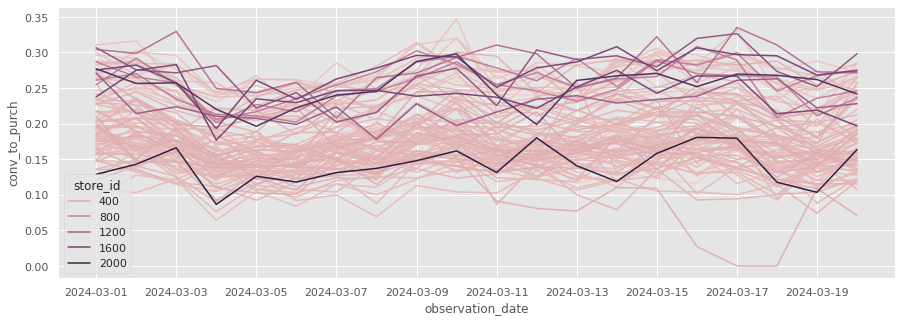

In [214]:
sns.lineplot(data=conv_df_added, x="observation_date", y="conv_to_purch", hue="store_id")

<AxesSubplot:xlabel='conv_to_purch', ylabel='was_avalilable_prc_v1'>

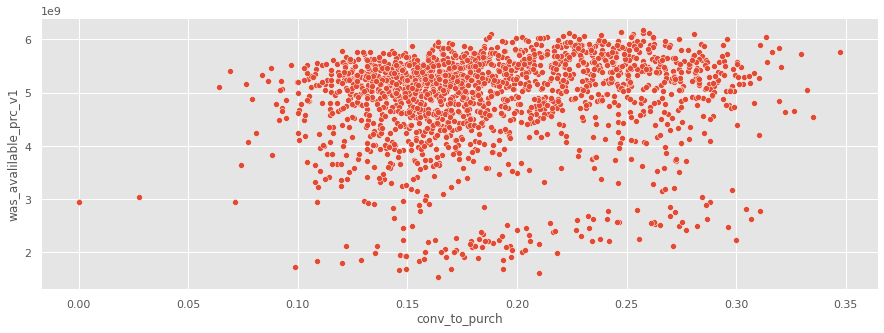

In [215]:
sns.scatterplot(data=conv_df_added, x="conv_to_purch", y="was_avalilable_prc_v1")

Не все sku одинаково важны, разберем по категориям 

In [208]:
scaler = StandardScaler()

X = conv_df_added[['was_avalilable_prc_v1',	'was_viewed','prev_day_conv_to_purch']]
X_normalized = scaler.fit_transform(X)

y = conv_df_added[['conv_to_purch']]
y_normalized = scaler.fit_transform(y)


reg = LinearRegression().fit(X_normalized, y_normalized)
print(reg.score(X_normalized, y_normalized))
print(reg.coef_)
print(reg.intercept_)

0.438813914651239
[[-0.32839174  0.11429953  0.7698705 ]]
[-7.69522547e-16]


In [ ]:
# Вывести самари и посмотреть что по значимости

### V2

In [216]:
index_cols = ['retailer_id', 'store_id'] + [el.strftime('%Y-%m-%d')+"_conv_v2" for el in pd.date_range(start = date_start, end = date_end)]
store_active_time_agg_pivot_v2 = \
    pd.pivot_table(store_active_time_agg, index=index_cols,
                        aggfunc="sum").reset_index()[index_cols]\
                            .melt(id_vars=['retailer_id', 'store_id'], var_name='date', value_name='was_avalilable_prc_v2')

In [217]:
store_active_time_agg_pivot_v2['observation_date'] = store_active_time_agg_pivot_v2['date']\
    .apply(lambda x: pd.to_datetime(x.replace('_conv_v2','')).date() )

In [218]:
conv_df_added_v2 = \
    conv_df.merge(store_active_time_agg_pivot_v2)

In [222]:
conv_df_added_v2['prev_day_conv_to_purch'] = conv_df_added_v2.groupby(['store_id'])['conv_to_purch'].shift(1).fillna(0)

In [227]:
scaler = StandardScaler()

X = conv_df_added_v2[['was_avalilable_prc_v2',	'was_viewed','prev_day_conv_to_purch']]
X_normalized = scaler.fit_transform(X)

y = conv_df_added_v2[['conv_to_purch']]
y_normalized = scaler.fit_transform(y)


reg = LinearRegression().fit(X_normalized, y_normalized)
print(reg.score(X_normalized, y_normalized))
print(reg.coef_)
print(reg.intercept_)



0.378591782894676
[[-0.15931277  0.11737887  0.691072  ]]
[-5.50192273e-16]


# Останавливаемся на v1 - смотримт процет доступных kvi и их время доступности от всех доступных kvi в сторе, (а не от всех возможных kvi), разбиваем по мастер категориям 

In [232]:
try:
    stocks_data_with_active_time
except:
    stocks_data_with_active_time = pd.read_feather('DATA-30893/stocks_data_with_active_time.feather')

In [288]:
product_mc = read_sql_query(f'''
select product_sku
    , master_category_id
    ,  dictGet('dict.ods__product_hub__master_category','name', master_category_id) as master_category_name
from ods.product_hub__product
where master_category_name is not null
                            ''')
product_mc.head()

,product_sku,master_category_id,master_category_name
0,15769286,108012,"Блины, оладьи, сырники"
1,15769287,108012,"Блины, оладьи, сырники"
2,15769288,108012,"Блины, оладьи, сырники"
3,15769289,101803,"Булочки, пироги, выпечка"
4,15769290,2100006002,"Семена, саженцы"


In [239]:
stocks_data_with_active_time_mc = \
    stocks_data_with_active_time.merge(product_mc, how = 'left')

In [241]:
dummies = pd.get_dummies(stocks_data_with_active_time_mc['master_category_name'])
stocks_data_with_active_time_mc = pd.concat([stocks_data_with_active_time_mc, dummies], axis=1)
stocks_data_with_active_time_mc

,index,retailer_id,store_id,product_sku,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,2024-03-11,2024-03-12,2024-03-13,2024-03-14,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20,master_category_id,master_category_name,Алкогольные подарки и наборы,Антифризы и охлаждающие жидкости,Батарейки,Безалкогольное пиво,"Блины, оладьи, сырники",Бренди,Бритвы,"Булочки, пироги, выпечка",Бумага для печати,Варенье и джем,Ватные диски и палочки,Вино,Виски,Влажные и сухие салфетки,Вода питьевая и минеральная,"Водка, саке, граппа",Все для выпечки и десертов,Газированные напитки,Гели для душа,"Горчица, хрен, аджика",Готовые консервированные блюда,"Готовые смеси для выпечки, десертов, напитков",Грибы,"Губки, тряпки, салфетки","Губки, щетки, салфетки",Дезодоранты,"Дезодоранты, саше",Десерты,Детские каши,"Детские пюре, фрикадельки",Детские смеси,Джин,Для губ,Для ухода за кожей,Емкости для хранения,Жевательные резинки,Закуски из рыбы и морепродуктов,Замороженные фрукты и ягоды,Защита от насекомых и грызунов,"Зелень, салаты, смеси",Зубные пасты и ополаскиватели,Зубные щетки и нити,Икра,Йогурты,Какао,Квас,Кетчуп,Кисломолочные продукты,Клей,Колбасы,"Кондиционеры, ополаскиватели для белья",Консервы из рыбы и морепродуктов,Конфеты и сладкие подарочные наборы,Коньяк,Корм и лакомства для птиц,Корма для животных,Косметические наборы,Кофе,Крабовые палочки и мясо,Крупы,"Кухонные ножи, ножницы, аксессуары",Лекарства,"Ликер, настойки",Майонез,Макаронные изделия и паста,"Мармелад, зефир, пастила",Масла,Мед,"Мерные емкости, воронки",Мешки для мусора,Молоко,Молочные коктейли и напитки,Морепродукты,Мороженое,Мочалки и губки,Мука,Мыло,Мясные деликатесы и копчености,Мясные и сырные снеки,Мясные консервы,Мясо,Мясо птицы,"Надувные матрасы, круги, игрушки",Наполнители,Овощные консервы и соленья,"Овощные полуфабрикаты, смеси","Оливки, маслины, каперсы",Орехи,Освежители воздуха,"Отбеливатели, пятновыводители",Отруби и клетчатка,Пасты и урбеч,Паштеты,"Пельмени, манты, вареники",Перчатки,"Печенье, пряники, вафли",Пиво,Подарочная упаковка,Подгузники и трусики,Полуфабрикаты из мяса и птицы,Полуфабрикаты из рыбы и морепродуктов,"Презервативы, лубриканты",Приправы,Продукты быстрого приготовления,Прокладки и тампоны,Пылесосы,Растительные масла,Ром,Рыба,Салаты и закуски,Сахар и сахарозаменители,Свежие овощи,Свежие фрукты,Свежие ягоды,Сгущенное молоко,Семечки,Сливки,Сливочное масло и маргарин,Сметана,Снеки из рыбы и морепродуктов,"Соки, нектары и морсы","Соленая, копченая, вяленая рыба",Соль,Сосиски и сардельки,"Соусы, маринады",Специи и пряности,Средства для бритья и депиляции,Средства для бытовой техники,Средства для ванных комнат и туалета,Средства для интимной гигиены,Средства для кухни и кухонной техники,Средства для мытья полов и стен,Средства для мытья посуды,"Средства для мытья стекол, зеркал",Средства для окрашивания волос,Средства для розжига,Средства для стирки,Средства для укладки волос,Средства после бритья,Субпродукты,Супы и основные блюда,"Сухари, баранки, сушки","Сухофрукты, фруктовые и овощные чипсы",Сырки,Сыры,Творог и творожная масса,Текила,Тесто и масса для лепки,Тесто и основа,Томатная паста,Торты и пирожные,Туалетная бумага и бумажные полотенца,Уголь и дрова,"Удобрения, грунты, средства по уходу",Уксус,Уход за волосами,Фильтры для воды и аксессуары,"Фольга, пакеты, бумага для выпечки","Халва, козинаки, пахлава","Хлеб, тосты, лаваш",Хлебцы,"Хлопья, мюсли, сухие завтраки",Холодный чай,"Цикорий, кэроб, кедрокофе",Чай,"Чипсы, сухарики, попкорн, снеки",Шампанское и игристое вино,"Швабры, насадки",Шоколад и шоколадные батончики,"Шпажки, зубочистки","Электрические щетки, ирригаторы",Энергетические напитки,Яйца
0,0,15,184,325488,114.575,86400.000,86400.0,86400.000,86400.000,86400.000,86400.0,86400.00,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,86400.0,86400.000,86400.0,86400.0,3.400001e+09,Средства для стирки,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [269]:
dates = [x.date() for x in pd.date_range(start = date_start, end = date_end)]
mcs = stocks_data_with_active_time_mc.columns.to_list()[26:]

In [264]:
stocks_data_with_active_time_mc_agg = \
    stocks_data_with_active_time_mc.groupby(\
    ['retailer_id','store_id'] + mcs).agg(['count','sum']).reset_index().drop(columns = ['master_category_id','master_category_name','index'])

In [291]:
stocks_data_with_active_time_mc_agg1 = pd.DataFrame()
for el in pd.date_range(start = date_start, end = date_end):
    x = el.strftime('%Y-%m-%d')

    tmp_df = stocks_data_with_active_time_mc_agg[['retailer_id','store_id']+mcs + [x]].copy()
    tmp_df['observation_date'] = el.date()
    
    tmp_df['count'] = tmp_df[(x,'count')]
    tmp_df['sum'] = tmp_df[(x,'sum')]
    tmp_df = tmp_df.drop(columns = [(x,'count'),(x,'sum')])
    tmp_df.columns = [x[0] for x in tmp_df.columns]
    
    stocks_data_with_active_time_mc_agg1 = stocks_data_with_active_time_mc_agg1.append(tmp_df)

stocks_data_with_active_time_mc_agg1.head()

,retailer_id,store_id,Алкогольные подарки и наборы,Антифризы и охлаждающие жидкости,Батарейки,Безалкогольное пиво,"Блины, оладьи, сырники",Бренди,Бритвы,"Булочки, пироги, выпечка",Бумага для печати,Варенье и джем,Ватные диски и палочки,Вино,Виски,Влажные и сухие салфетки,Вода питьевая и минеральная,"Водка, саке, граппа",Все для выпечки и десертов,Газированные напитки,Гели для душа,"Горчица, хрен, аджика",Готовые консервированные блюда,"Готовые смеси для выпечки, десертов, напитков",Грибы,"Губки, тряпки, салфетки","Губки, щетки, салфетки",Дезодоранты,"Дезодоранты, саше",Десерты,Детские каши,"Детские пюре, фрикадельки",Детские смеси,Джин,Для губ,Для ухода за кожей,Емкости для хранения,Жевательные резинки,Закуски из рыбы и морепродуктов,Замороженные фрукты и ягоды,Защита от насекомых и грызунов,"Зелень, салаты, смеси",Зубные пасты и ополаскиватели,Зубные щетки и нити,Икра,Йогурты,Какао,Квас,Кетчуп,Кисломолочные продукты,Клей,Колбасы,"Кондиционеры, ополаскиватели для белья",Консервы из рыбы и морепродуктов,Конфеты и сладкие подарочные наборы,Коньяк,Корм и лакомства для птиц,Корма для животных,Косметические наборы,Кофе,Крабовые палочки и мясо,Крупы,"Кухонные ножи, ножницы, аксессуары",Лекарства,"Ликер, настойки",Майонез,Макаронные изделия и паста,"Мармелад, зефир, пастила",Масла,Мед,"Мерные емкости, воронки",Мешки для мусора,Молоко,Молочные коктейли и напитки,Морепродукты,Мороженое,Мочалки и губки,Мука,Мыло,Мясные деликатесы и копчености,Мясные и сырные снеки,Мясные консервы,Мясо,Мясо птицы,"Надувные матрасы, круги, игрушки",Наполнители,Овощные консервы и соленья,"Овощные полуфабрикаты, смеси","Оливки, маслины, каперсы",Орехи,Освежители воздуха,"Отбеливатели, пятновыводители",Отруби и клетчатка,Пасты и урбеч,Паштеты,"Пельмени, манты, вареники",Перчатки,"Печенье, пряники, вафли",Пиво,Подарочная упаковка,Подгузники и трусики,Полуфабрикаты из мяса и птицы,Полуфабрикаты из рыбы и морепродуктов,"Презервативы, лубриканты",Приправы,Продукты быстрого приготовления,Прокладки и тампоны,Пылесосы,Растительные масла,Ром,Рыба,Салаты и закуски,Сахар и сахарозаменители,Свежие овощи,Свежие фрукты,Свежие ягоды,Сгущенное молоко,Семечки,Сливки,Сливочное масло и маргарин,Сметана,Снеки из рыбы и морепродуктов,"Соки, нектары и морсы","Соленая, копченая, вяленая рыба",Соль,Сосиски и сардельки,"Соусы, маринады",Специи и пряности,Средства для бритья и депиляции,Средства для бытовой техники,Средства для ванных комнат и туалета,Средства для интимной гигиены,Средства для кухни и кухонной техники,Средства для мытья полов и стен,Средства для мытья посуды,"Средства для мытья стекол, зеркал",Средства для окрашивания волос,Средства для розжига,Средства для стирки,Средства для укладки волос,Средства после бритья,Субпродукты,Супы и основные блюда,"Сухари, баранки, сушки","Сухофрукты, фруктовые и овощные чипсы",Сырки,Сыры,Творог и творожная масса,Текила,Тесто и масса для лепки,Тесто и основа,Томатная паста,Торты и пирожные,Туалетная бумага и бумажные полотенца,Уголь и дрова,"Удобрения, грунты, средства по уходу",Уксус,Уход за волосами,Фильтры для воды и аксессуары,"Фольга, пакеты, бумага для выпечки","Халва, козинаки, пахлава","Хлеб, тосты, лаваш",Хлебцы,"Хлопья, мюсли, сухие завтраки",Холодный чай,"Цикорий, кэроб, кедрокофе",Чай,"Чипсы, сухарики, попкорн, снеки",Шампанское и игристое вино,"Швабры, насадки",Шоколад и шоколадные батончики,"Шпажки, зубочистки","Электрические щетки, ирригаторы",Энергетические напитки,Яйца,observation_date,count,sum
0,15,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2024-03-01,25,1036390.637
1,15,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [292]:
stocks_data_with_active_time_mc_agg1['was_available_prc'] = stocks_data_with_active_time_mc_agg1['sum']/stocks_data_with_active_time_mc_agg1['count']*seconds_on_day

In [297]:
conv_df_added_mc = \
    conv_df.merge(stocks_data_with_active_time_mc_agg1)
conv_df_added_mc['prev_day_conv_to_purch'] = conv_df_added_mc.groupby(['store_id'])['conv_to_purch'].shift(1)
conv_df_added_mc = conv_df_added_mc[~conv_df_added_mc['prev_day_conv_to_purch'].isna()]

conv_df_added_mc = conv_df_added_mc.drop(columns = ['count','sum','was_completed','observation_date','store_id','retailer_id'])
conv_df_added_mc.head()

,was_viewed,conv_to_purch,Алкогольные подарки и наборы,Антифризы и охлаждающие жидкости,Батарейки,Безалкогольное пиво,"Блины, оладьи, сырники",Бренди,Бритвы,"Булочки, пироги, выпечка",Бумага для печати,Варенье и джем,Ватные диски и палочки,Вино,Виски,Влажные и сухие салфетки,Вода питьевая и минеральная,"Водка, саке, граппа",Все для выпечки и десертов,Газированные напитки,Гели для душа,"Горчица, хрен, аджика",Готовые консервированные блюда,"Готовые смеси для выпечки, десертов, напитков",Грибы,"Губки, тряпки, салфетки","Губки, щетки, салфетки",Дезодоранты,"Дезодоранты, саше",Десерты,Детские каши,"Детские пюре, фрикадельки",Детские смеси,Джин,Для губ,Для ухода за кожей,Емкости для хранения,Жевательные резинки,Закуски из рыбы и морепродуктов,Замороженные фрукты и ягоды,Защита от насекомых и грызунов,"Зелень, салаты, смеси",Зубные пасты и ополаскиватели,Зубные щетки и нити,Икра,Йогурты,Какао,Квас,Кетчуп,Кисломолочные продукты,Клей,Колбасы,"Кондиционеры, ополаскиватели для белья",Консервы из рыбы и морепродуктов,Конфеты и сладкие подарочные наборы,Коньяк,Корм и лакомства для птиц,Корма для животных,Косметические наборы,Кофе,Крабовые палочки и мясо,Крупы,"Кухонные ножи, ножницы, аксессуары",Лекарства,"Ликер, настойки",Майонез,Макаронные изделия и паста,"Мармелад, зефир, пастила",Масла,Мед,"Мерные емкости, воронки",Мешки для мусора,Молоко,Молочные коктейли и напитки,Морепродукты,Мороженое,Мочалки и губки,Мука,Мыло,Мясные деликатесы и копчености,Мясные и сырные снеки,Мясные консервы,Мясо,Мясо птицы,"Надувные матрасы, круги, игрушки",Наполнители,Овощные консервы и соленья,"Овощные полуфабрикаты, смеси","Оливки, маслины, каперсы",Орехи,Освежители воздуха,"Отбеливатели, пятновыводители",Отруби и клетчатка,Пасты и урбеч,Паштеты,"Пельмени, манты, вареники",Перчатки,"Печенье, пряники, вафли",Пиво,Подарочная упаковка,Подгузники и трусики,Полуфабрикаты из мяса и птицы,Полуфабрикаты из рыбы и морепродуктов,"Презервативы, лубриканты",Приправы,Продукты быстрого приготовления,Прокладки и тампоны,Пылесосы,Растительные масла,Ром,Рыба,Салаты и закуски,Сахар и сахарозаменители,Свежие овощи,Свежие фрукты,Свежие ягоды,Сгущенное молоко,Семечки,Сливки,Сливочное масло и маргарин,Сметана,Снеки из рыбы и морепродуктов,"Соки, нектары и морсы","Соленая, копченая, вяленая рыба",Соль,Сосиски и сардельки,"Соусы, маринады",Специи и пряности,Средства для бритья и депиляции,Средства для бытовой техники,Средства для ванных комнат и туалета,Средства для интимной гигиены,Средства для кухни и кухонной техники,Средства для мытья полов и стен,Средства для мытья посуды,"Средства для мытья стекол, зеркал",Средства для окрашивания волос,Средства для розжига,Средства для стирки,Средства для укладки волос,Средства после бритья,Субпродукты,Супы и основные блюда,"Сухари, баранки, сушки","Сухофрукты, фруктовые и овощные чипсы",Сырки,Сыры,Творог и творожная масса,Текила,Тесто и масса для лепки,Тесто и основа,Томатная паста,Торты и пирожные,Туалетная бумага и бумажные полотенца,Уголь и дрова,"Удобрения, грунты, средства по уходу",Уксус,Уход за волосами,Фильтры для воды и аксессуары,"Фольга, пакеты, бумага для выпечки","Халва, козинаки, пахлава","Хлеб, тосты, лаваш",Хлебцы,"Хлопья, мюсли, сухие завтраки",Холодный чай,"Цикорий, кэроб, кедрокофе",Чай,"Чипсы, сухарики, попкорн, снеки",Шампанское и игристое вино,"Швабры, насадки",Шоколад и шоколадные батончики,"Шпажки, зубочистки","Электрические щетки, ирригаторы",Энергетические напитки,Яйца,was_available_prc,prev_day_conv_to_purch
1,686,0.274052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.222709e+09,0.274052
2,686,0.274052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [298]:
scaler = StandardScaler()

X = conv_df_added_mc.drop(columns = ['conv_to_purch',''])
X_normalized = scaler.fit_transform(X)

y = conv_df_added_mc[['conv_to_purch']]
y_normalized = scaler.fit_transform(y)


reg = LinearRegression().fit(X_normalized, y_normalized)
print(reg.score(X_normalized, y_normalized))
print(reg.coef_)
print(reg.intercept_)

0.9983638040352534
[[ 3.56380448e-04 -8.44869607e+08 -8.54149737e+08 -7.50873196e+08
  -8.58751292e+08 -8.58751292e+08 -8.06656542e+08 -8.58751292e+08
  -8.58751292e+08 -8.54149737e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -5.57085715e+08 -8.58751292e+08 -5.84880930e+08
  -8.58751292e+08 -8.01748954e+08 -8.58751292e+08 -8.54149737e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.40190181e+08
  -8.58751292e+08 -8.58751292e+08 -8.54149737e+08 -8.54149737e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -8.49522648e+08 -8.58751292e+08 -8.58751292e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.54149737e+08
  -8.58751292e+08 -8.58751292e+08 -8.58751292e+08 -8.5875

In [302]:
pd.DataFrame({'labels':X.columns.to_list(), 'coef':reg.coef_[0]}).sort_values(by = 'coef', ascending = False).head(10)

,labels,coef
175,prev_day_conv_to_purch,9.991416e-01
0,was_viewed,3.563804e-04
174,was_available_prc,-1.659823e-04
106,Пылесосы,-1.546885e+08
114,Свежие ягоды,-3.092867e+08
83,"Надувные матрасы, круги, игрушки",-4.090283e+08
21,Готовые консервированные блюда,-5.570857e+08
23,Грибы,-5.848809e+08
170,"Шпажки, зубочистки",-6.789461e+08
153,Уголь и дрова,-6.905079e+08


In [303]:
pd.DataFrame({'labels':X.columns.to_list(), 'coef':reg.coef_[0]}).sort_values(by = 'coef', ascending = False).tail(10)

,labels,coef
81,Мясо,-8.587513e+08
109,Рыба,-8.587513e+08
140,Субпродукты,-8.587513e+08
167,Шампанское и игристое вино,-8.587513e+08
87,"Оливки, маслины, каперсы",-8.587513e+08
31,Детские смеси,-8.587513e+08
99,Подгузники и трусики,-8.587513e+08
127,Средства для бритья и депиляции,-8.587513e+08
40,"Зелень, салаты, смеси",-8.587513e+08
57,Косметические наборы,-8.587513e+08


### Удалим prev_day_conv_to_purch

In [304]:
conv_df_added_mc_1 = \
    conv_df.merge(stocks_data_with_active_time_mc_agg1)

conv_df_added_mc_1 = conv_df_added_mc_1.drop(columns = ['count','sum','was_completed','observation_date','store_id','retailer_id'])
conv_df_added_mc_1.head()

,was_viewed,conv_to_purch,Алкогольные подарки и наборы,Антифризы и охлаждающие жидкости,Батарейки,Безалкогольное пиво,"Блины, оладьи, сырники",Бренди,Бритвы,"Булочки, пироги, выпечка",Бумага для печати,Варенье и джем,Ватные диски и палочки,Вино,Виски,Влажные и сухие салфетки,Вода питьевая и минеральная,"Водка, саке, граппа",Все для выпечки и десертов,Газированные напитки,Гели для душа,"Горчица, хрен, аджика",Готовые консервированные блюда,"Готовые смеси для выпечки, десертов, напитков",Грибы,"Губки, тряпки, салфетки","Губки, щетки, салфетки",Дезодоранты,"Дезодоранты, саше",Десерты,Детские каши,"Детские пюре, фрикадельки",Детские смеси,Джин,Для губ,Для ухода за кожей,Емкости для хранения,Жевательные резинки,Закуски из рыбы и морепродуктов,Замороженные фрукты и ягоды,Защита от насекомых и грызунов,"Зелень, салаты, смеси",Зубные пасты и ополаскиватели,Зубные щетки и нити,Икра,Йогурты,Какао,Квас,Кетчуп,Кисломолочные продукты,Клей,Колбасы,"Кондиционеры, ополаскиватели для белья",Консервы из рыбы и морепродуктов,Конфеты и сладкие подарочные наборы,Коньяк,Корм и лакомства для птиц,Корма для животных,Косметические наборы,Кофе,Крабовые палочки и мясо,Крупы,"Кухонные ножи, ножницы, аксессуары",Лекарства,"Ликер, настойки",Майонез,Макаронные изделия и паста,"Мармелад, зефир, пастила",Масла,Мед,"Мерные емкости, воронки",Мешки для мусора,Молоко,Молочные коктейли и напитки,Морепродукты,Мороженое,Мочалки и губки,Мука,Мыло,Мясные деликатесы и копчености,Мясные и сырные снеки,Мясные консервы,Мясо,Мясо птицы,"Надувные матрасы, круги, игрушки",Наполнители,Овощные консервы и соленья,"Овощные полуфабрикаты, смеси","Оливки, маслины, каперсы",Орехи,Освежители воздуха,"Отбеливатели, пятновыводители",Отруби и клетчатка,Пасты и урбеч,Паштеты,"Пельмени, манты, вареники",Перчатки,"Печенье, пряники, вафли",Пиво,Подарочная упаковка,Подгузники и трусики,Полуфабрикаты из мяса и птицы,Полуфабрикаты из рыбы и морепродуктов,"Презервативы, лубриканты",Приправы,Продукты быстрого приготовления,Прокладки и тампоны,Пылесосы,Растительные масла,Ром,Рыба,Салаты и закуски,Сахар и сахарозаменители,Свежие овощи,Свежие фрукты,Свежие ягоды,Сгущенное молоко,Семечки,Сливки,Сливочное масло и маргарин,Сметана,Снеки из рыбы и морепродуктов,"Соки, нектары и морсы","Соленая, копченая, вяленая рыба",Соль,Сосиски и сардельки,"Соусы, маринады",Специи и пряности,Средства для бритья и депиляции,Средства для бытовой техники,Средства для ванных комнат и туалета,Средства для интимной гигиены,Средства для кухни и кухонной техники,Средства для мытья полов и стен,Средства для мытья посуды,"Средства для мытья стекол, зеркал",Средства для окрашивания волос,Средства для розжига,Средства для стирки,Средства для укладки волос,Средства после бритья,Субпродукты,Супы и основные блюда,"Сухари, баранки, сушки","Сухофрукты, фруктовые и овощные чипсы",Сырки,Сыры,Творог и творожная масса,Текила,Тесто и масса для лепки,Тесто и основа,Томатная паста,Торты и пирожные,Туалетная бумага и бумажные полотенца,Уголь и дрова,"Удобрения, грунты, средства по уходу",Уксус,Уход за волосами,Фильтры для воды и аксессуары,"Фольга, пакеты, бумага для выпечки","Халва, козинаки, пахлава","Хлеб, тосты, лаваш",Хлебцы,"Хлопья, мюсли, сухие завтраки",Холодный чай,"Цикорий, кэроб, кедрокофе",Чай,"Чипсы, сухарики, попкорн, снеки",Шампанское и игристое вино,"Швабры, насадки",Шоколад и шоколадные батончики,"Шпажки, зубочистки","Электрические щетки, ирригаторы",Энергетические напитки,Яйца,was_available_prc
0,686,0.274052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.581766e+09
1,686,0.274052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [305]:
scaler = StandardScaler()

X = conv_df_added_mc_1.drop(columns = ['conv_to_purch'])
X_normalized = scaler.fit_transform(X)

y = conv_df_added_mc_1[['conv_to_purch']]
y_normalized = scaler.fit_transform(y)


reg = LinearRegression().fit(X_normalized, y_normalized)
print(reg.score(X_normalized, y_normalized))
print(reg.coef_)
print(reg.intercept_)

0.02629826891168552
[[1.31185532e-01 2.57193998e+10 2.60019048e+10 2.28579702e+10
  2.61419849e+10 2.61419849e+10 2.45561212e+10 2.61419849e+10
  2.61419849e+10 2.60019048e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 1.69587152e+10 2.61419849e+10 1.78048534e+10
  2.61419849e+10 2.44067249e+10 2.61419849e+10 2.60019048e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.55769492e+10
  2.61419849e+10 2.61419849e+10 2.60019048e+10 2.60019048e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.58610473e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.60019048e+10
  2.61419849e+10 2.61419849e+10 2.61419849e+10 2.61419849e+10
  2.61419849e+10 2.42563887e+10 2.61419849e+10 2.6

In [ ]:
pd.DataFrame({'labels':X.columns.to_list(), 'coef':reg.coef_[0]}).sort_values(by = 'coef', ascending = False).head(10)

,labels,coef
175,prev_day_conv_to_purch,9.991416e-01
0,was_viewed,3.563804e-04
174,was_available_prc,-1.659823e-04
106,Пылесосы,-1.546885e+08
114,Свежие ягоды,-3.092867e+08
83,"Надувные матрасы, круги, игрушки",-4.090283e+08
21,Готовые консервированные блюда,-5.570857e+08
23,Грибы,-5.848809e+08
170,"Шпажки, зубочистки",-6.789461e+08
153,Уголь и дрова,-6.905079e+08


In [ ]:
pd.DataFrame({'labels':X.columns.to_list(), 'coef':reg.coef_[0]}).sort_values(by = 'coef', ascending = False).tail(10)

,labels,coef
81,Мясо,-8.587513e+08
109,Рыба,-8.587513e+08
140,Субпродукты,-8.587513e+08
167,Шампанское и игристое вино,-8.587513e+08
87,"Оливки, маслины, каперсы",-8.587513e+08
31,Детские смеси,-8.587513e+08
99,Подгузники и трусики,-8.587513e+08
127,Средства для бритья и депиляции,-8.587513e+08
40,"Зелень, салаты, смеси",-8.587513e+08
57,Косметические наборы,-8.587513e+08
